## Scalability of distributed deep learning

<a id='dl'></a>
### Scalability of gradient descent
Lets consider data parallel distributed gradient descent. 
<code>
  *t<sub>cp</sub>(n,c,p) = c/(np)*
</code>
where *`n`* is number of nodes, *`p`* is the computational power of the node, *`c`* is number of floating point operations.
<code>
  *t<sub>cm</sub>(n,w,b) = 2(w/b)log(n)*
</code>
where *`n`* is number of nodes, *`b`* is bandwidth, *`w`* is the size of the weights in bits.

In [1]:
import math
def tcp(n, flops, p):
    return flops / (n * p)
def tcm(n, weights, b):
    return 2 * (32 * weights / b) * math.log (n, 2)
def t(n, weights, flops, b, p):
    return tcp(n, flops, p) + tcm(n, weights, b)
def s(k, n, weights, flops, b, p):
    return t(k, weights, flops, b, p) / t(n, weights, flops, b, p)
def e(k, n, weights, flops, b, p):
    return s(k, n, weights, flops, b, p) / n
def sr(n, weights, flops, b, p):
    return t(n - 1, weights, flops, b, p) / t(n, weights, flops, b, p)

### Logistic regression

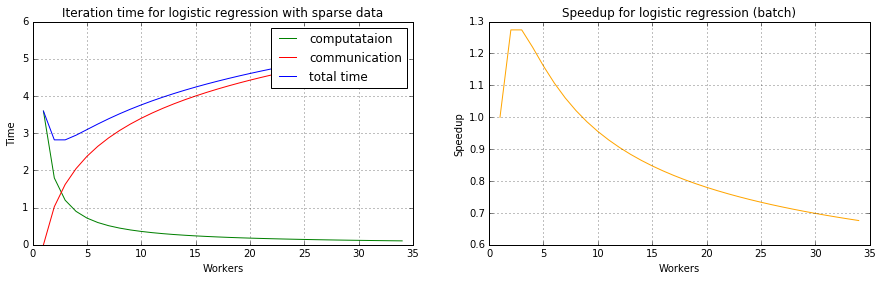

In [31]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
#Criteo & MS
weights = 16E6
batch = 2.3E9 # Batch LBFGS
nonZero = 125 # 125 non-zero features
#  
flops = 2 * nonZero * batch
# Network 1Gb/s (peak can be 100%)
b = 1E9
# Standard CPU 200 GFlops (peak is 80%)
p = 0.8 * 200E9
n = np.arange(1, 35)
#vtcp = np.vectorize(tcp)
#vtcm = np.vectorize(tcm)
#vt = np.vectorize(t)
tcpData = np.vectorize(tcp)(n, flops, p)
tcmData = np.vectorize(tcm)(n, weights, b)
tData = np.vectorize(t)(n, weights, flops, b, p)
plt.figure(1, figsize=(15, 4))
plt.subplot(121)
ax = plt.gca()
ax.grid(True)
leg1, = plt.plot(n,tcpData, color="green", label='computataion')
leg2, = plt.plot(n,tcmData, color="red", label='communication')
leg3, = plt.plot(n, tData, color="blue", label='total time')
plt.ylabel("Time")
plt.xlabel("Workers")
plt.title("Iteration time for logistic regression with sparse data")
plt.legend(handles=[leg1, leg2, leg3])
sData = np.vectorize(s)(1, n, weights, flops, b, p)
plt.subplot(122)
ax = plt.gca()
ax.grid(True)
leg1, = plt.plot(n, sData, color="orange")
plt.ylabel("Speedup")
plt.xlabel("Workers")
plt.title("Speedup for logistic regression (batch)")

### Fully connected

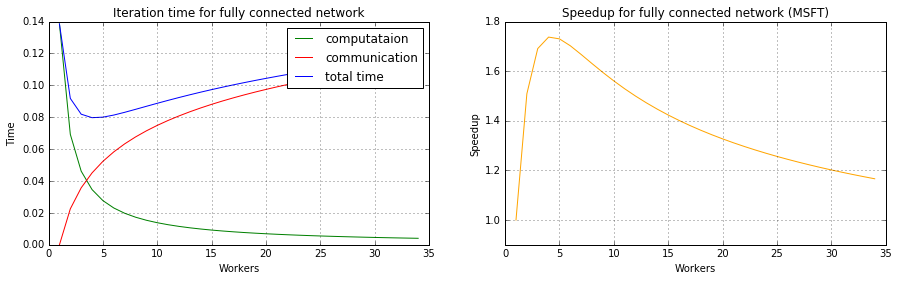

In [32]:
#MSFT
weights = 45.1E6
batch = 1024 #SGD
# weights = MULT-ADD operations, 3x for training, 2x for FLOPS
flops = 2 * weights * 3 * batch
# PCI express v3 16GB/s (peak can be 100%)
b = 8 * 16E9
# nVidia 4 TFlops (peak is 50%)
p = 0.5 * 4E12
n = np.arange(1, 35)
#vtcp = np.vectorize(tcp)
#vtcm = np.vectorize(tcm)
#vt = np.vectorize(t)
tcpData = np.vectorize(tcp)(n, flops, p)
tcmData = np.vectorize(tcm)(n, weights, b)
tData = np.vectorize(t)(n, weights, flops, b, p)
plt.figure(1, figsize=(15, 4))
plt.subplot(121)
ax = plt.gca()
ax.grid(True)
leg1, = plt.plot(n,tcpData, color="green", label='computataion')
leg2, = plt.plot(n,tcmData, color="red", label='communication')
leg3, = plt.plot(n, tData, color="blue", label='total time')
plt.ylabel("Time")
plt.xlabel("Workers")
plt.title("Iteration time for fully connected network")
plt.legend(handles=[leg1, leg2, leg3])
sData = np.vectorize(s)(1, n, weights, flops, b, p)
plt.subplot(122)
ax = plt.gca()
ax.grid(True)
leg1, = plt.plot(n, sData, color="orange")
plt.ylabel("Speedup")
plt.xlabel("Workers")
plt.title("Speedup for fully connected network (MSFT)")

In [4]:
print("Speedup 1 node vs 4:", t(1, weights, flops, b, p) / t(4,  weights, flops, b, p))
print("Speedup 4 nodes vs 25:", t(4, weights, flops, b, p) / t(25,  weights, flops, b, p))

Speedup 1 node vs 4: 1.7375565610859731
Speedup 4 nodes vs 25: 0.7231651448215021


### Convolutional

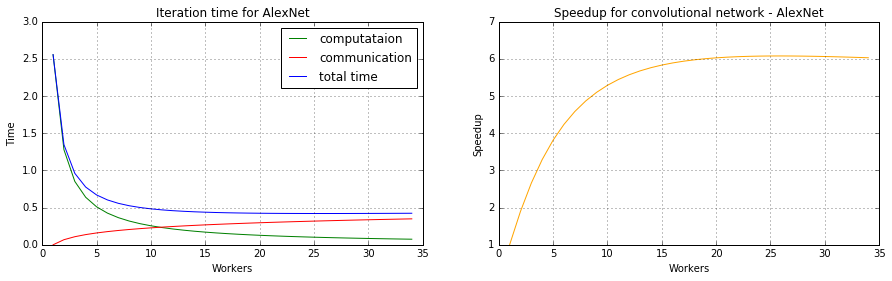

In [30]:
#Google AlexNet 32 bit weights
weights = 60E6
# MULT-ADD ops, 2x for FLOPS, 3x for training
flops = 2 * 832E6 * 3 * 1024
# Infiniband 56Gb/s (peak can be 100%)
b = 56E9
n = np.arange(1, 35)
tcpData = np.vectorize(tcp)(n, flops, p)
tcmData = np.vectorize(tcm)(n, weights, b)
tData = np.vectorize(t)(n, weights, flops, b, p)
plt.figure(1, figsize=(15, 4))
plt.subplot(121)
ax = plt.gca()
ax.grid(True)
leg1, = plt.plot(n,tcpData, color="green", label='computataion')
leg2, = plt.plot(n,tcmData, color="red", label='communication')
leg3, = plt.plot(n, tData, color="blue", label='total time')
plt.ylabel("Time")
plt.xlabel("Workers")
plt.title("Iteration time for AlexNet")
plt.legend(handles=[leg1, leg2, leg3])
sData = np.vectorize(s)(1, n, weights, flops, b, p)
plt.subplot(122)
ax = plt.gca()
ax.grid(True)
leg1, = plt.plot(n, sData, color="orange")
plt.ylabel("Speedup")
plt.xlabel("Workers")
plt.title("Speedup for convolutional network - AlexNet")

Speedups:

In [8]:
print("Speedup 1 node vs 25:", t(1, weights, flops, b, p) / t(25,  weights, flops, b, p))
print("Speedup 25 nodes vs 100:", t(25, weights, flops, b, p) / t(100,  weights, flops, b, p))

Speedup 1 node vs 25: 19.79209453394258
Speedup 25 nodes vs 100: 2.016315720257963


### Estimation for published models
Lets consider the published models. 
  - Logistic regression
      - Click trough rate (CTR) prediction 16M weights, 125 non-zero features [6]
  - Fully connected
      - MSFT speech: 45.1M weights [3]
  - Convolutional 
      - AlexNet, convolutional neural network, 60M weights, 832M MULT-ADD operations for inference [1]
      - Inception v3, cnn, 25M weights, 5B MULT-ADD operations for inference [2]
  - Recurrent
      - DeepSpeech [tbd]

Hardware and other settings:
  - 16 GB/s PCI-express or Infiniband interconnect
  - 4TFlops nVidia GPU
  - 1024 mini batch size (divided by the number of nodes)

TODO: consider the speedup for graphs

### Spark ANN benchmark

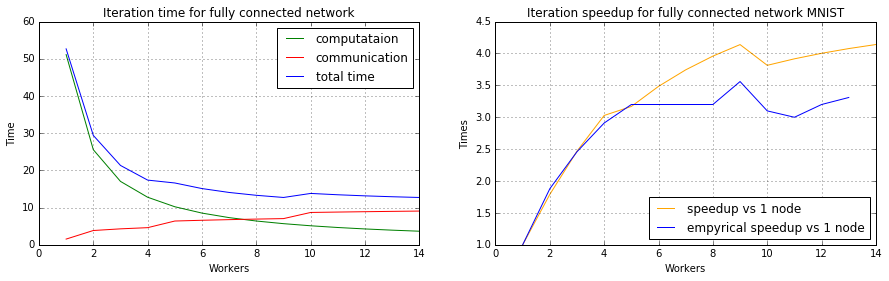

In [36]:
import math
# model has different communication: 
# master to workers: torrent broadcast ~log(n)
# workers to master: 2 waves of reduceByKey then reduce 2 remaining to master
def tcm_spark(n, weights, b):
    return (32 * weights / b) * math.log (n, 2) + 2 * (32 * weights / b) * math.ceil(math.sqrt(n))
def t_spark(n, weights, flops, b, p):
    return tcp(n, flops, p) + tcm_spark(n, weights, b)
def s_spark(k, n, weights, flops, b, p):
    return t_spark(k, weights, flops, b, p) / t_spark(n, weights, flops, b, p)
#Spark ANN double precision
weights = 12E6
batch = 60000 #MNIST
# weights = MULT-ADD operations, 3x for training, 2x for FLOPS
flops = 2 * weights * 3 * batch
# 1 Gbit network (peak can be 100%)
b = 1E9
# Xeon 3-1240  3.3 GHz (peak is 80%)
p = 0.8 * 211.2E9
n = np.arange(1, 15)
# correct for double precision
weights = weights * 2
flops = flops * 2
tcpData = np.vectorize(tcp)(n, flops, p)
tcmData = np.vectorize(tcm_spark)(n, weights, b)
tData = np.vectorize(t_spark)(n, weights, flops, b, p)
plt.figure(1, figsize=(15, 4))
plt.subplot(121)
ax = plt.gca()
ax.grid(True)
leg1, = plt.plot(n,tcpData, color="green", label='computataion')
leg2, = plt.plot(n,tcmData, color="red", label='communication')
leg3, = plt.plot(n, tData, color="blue", label='total time')
plt.ylabel("Time")
plt.xlabel("Workers")
plt.title("Iteration time for fully connected network")
plt.legend(handles=[leg1, leg2, leg3])
# speedup plot
plt.subplot(122)
ax = plt.gca()
ax.grid(True)
sData = np.vectorize(s_spark)(1, n, weights, flops, b, p)
srData = np.vectorize(sr)(r, weights, flops, b, p)
eData = np.vectorize(e)(1, n, weights, flops, b, p)
leg1, = plt.plot(n,sData, color="orange", label='speedup vs 1 node')
leg2, = plt.plot([1,2,3,4,5,6,7,8,9,10,11,12,13], 
                 [1, 1.88, 2.46, 2.91, 3.2, 3.2, 3.2, 3.2, 3.56, 3.1, 3, 3.2, 3.31],
                 color="blue", label='empyrical speedup vs 1 node')
plt.ylabel("Times")
plt.xlabel("Workers")
plt.title("Iteration speedup for fully connected network MNIST")
plt.legend(handles=[leg1, leg2], loc=4)

In [6]:
print("Speedup 1 node vs 5:", t(1, weights, flops, b, p) / t(5,  weights, flops, b, p))
print("Speedup 5 nodes vs 13:", t_spark(5, weights, flops, b, p) / t_spark(13,  weights, flops, b, p))

Speedup 1 node vs 5: 3.707211437478451
Speedup 5 nodes vs 13: 1.2863120231081933


### Google Inception v3

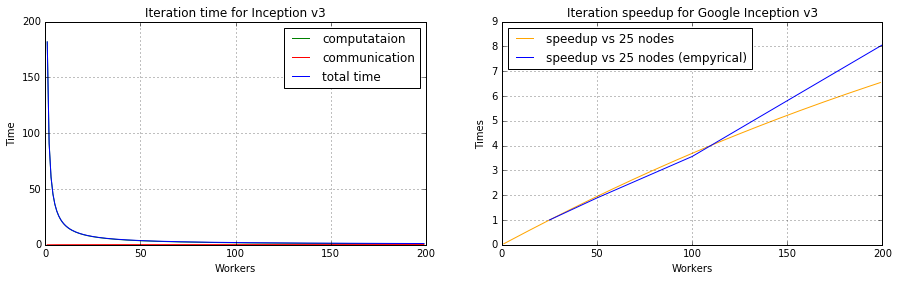

In [37]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
#Google Inception v3
weights = 25E6
flops = 2 * 5E9 * 3 * 1024
# Infiniband 56Gb/s (peak can be 100%)
b = 56E9
n = np.arange(1, 200)
r = np.arange(2, 200)
tcpData = np.vectorize(tcp)(n, flops, p)
tcmData = np.vectorize(tcm)(n, weights, b)
tData = np.vectorize(t)(n, weights, flops, b, p)
plt.figure(1, figsize=(15, 4))
plt.subplot(121)
ax = plt.gca()
ax.grid(True)
leg1, = plt.plot(n,tcpData, color="green", label='computataion')
leg2, = plt.plot(n,tcmData, color="red", label='communication')
leg3, = plt.plot(n, tData, color="blue", label='total time')
plt.ylabel("Time")
plt.xlabel("Workers")
plt.title("Iteration time for Inception v3")
plt.legend(handles=[leg1, leg2, leg3])
# speedup plot
plt.subplot(122)
ax = plt.gca()
ax.grid(True)
sData = np.vectorize(s)(25, n, weights, flops, b, p)
srData = np.vectorize(sr)(r, weights, flops, b, p)
paperData = [1, 2, 3]
leg1, = plt.plot(n,sData, color="orange", label='speedup vs 25 nodes')
leg2, = plt.plot([25, 50, 100, 200], [1, 1.89, 3.56, 8.06], color="blue", label='speedup vs 25 nodes (empyrical)')
plt.ylabel("Times")
plt.xlabel("Workers")
plt.title("Iteration speedup for Google Inception v3")
plt.legend(handles=[leg1, leg2], loc=2)

Speedups:

In [10]:
print("Speedup 1 node vs 25:", t(1, weights, flops, b, p) / t(25,  weights, flops, b, p))
print("Speedup 50 nodes vs 25:", t(25, weights, flops, b, p) / t(50,  weights, flops, b, p))
print("Speedup 100 nodes vs 25:", t(25, weights, flops, b, p) / t(100,  weights, flops, b, p))
print("Speedup 200 nodes vs 25:", t(25, weights, flops, b, p) / t(200,  weights, flops, b, p))

Speedup 1 node vs 25: 24.55207873189275
Speedup 50 nodes vs 25: 1.950014843771176
Speedup 100 nodes vs 25: 3.687941093189816
Speedup 200 nodes vs 25: 6.568067028949954


Interestingly, we get speedups similar to empyrical results reported in [5]:
  - 25 relative to 1: 25
  - 100 relative to 25: 3.56
  - 200 relative to 25: 8.06

## References
  1. Krizhevsky, Alex, Ilya Sutskever, and Geoffrey E. Hinton. "Imagenet classification with deep convolutional neural networks." Advances in neural information processing systems. 2012. (slides: http://vision.stanford.edu/teaching/cs231b_spring1415/slides/alexnet_tugce_kyunghee.pdf)
  2. Szegedy, Christian, et al. "Rethinking the Inception Architecture for Computer Vision." arXiv preprint arXiv:1512.00567 (2015).
  3. Seide, Frank, Gang Li, and Dong Yu. "Conversational Speech Transcription Using Context-Dependent Deep Neural Networks." Interspeech. 2011.
  4. Iandola, Forrest N., et al. "FireCaffe: near-linear acceleration of deep neural network training on compute clusters." arXiv preprint arXiv:1511.00175 (2015).
  5. Chen, Jianmin, et al. "Revisiting Distributed Synchronous SGD." arXiv preprint arXiv:1604.00981 (2016).
  6. Chapelle, Olivier, Eren Manavoglu, and Romer Rosales. "Simple and scalable response prediction for display advertising." ACM Transactions on Intelligent Systems and Technology (TIST) 5.4 (2015): 61.
  